# Employee Retention
## Goal
Employee turn-over is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

## Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13.

For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

### Project goal
As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:
1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.
2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

### Data
The table is:"employee_retention" - comprehensive information about employees.

Columns:
employee_id : id of the employee. Unique by employee per company company_id : company id.

dept : employee dept

seniority : number of yrs of work experience when hired

salary: avg yearly salary of the employee during her tenure within the company join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

## Data exploration

In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [74]:
data = pd.read_csv('employee_retention_data.csv')

In [75]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [76]:
# know the data type of each columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [77]:
# change object data type to date data type 
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [78]:
# Null information
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [79]:
# Make sure the unique values are as expected
for col in ['company_id', 'dept', 'seniority']:
    print (data[col].unique())

[ 7  4  2  9  1  6 10  5  3  8 11 12]
['customer_service' 'marketing' 'data_science' 'engineer' 'sales' 'design']
[28 20 14 23 21  4  7 13 17  1 10  6 19 15 26 27  5 18 16 25  9  2 29  3
  8 22 24 12 11 98 99]


In [80]:
data[data['seniority']>30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [81]:
data = data[data['seniority']<30]

In [87]:
data['quit'] = 1-data['quit_date'].isnull()

## Employee Churn Analysis

In [88]:
# Separate stay and quit data
quit_data = data[data['quit']== 1]
stay_data = data[data['quit']==0]

In [89]:
quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,1


### Feature Engineering

In [91]:
# Total working days
work_days = quit_data['quit_date'] - quit_data['join_date']

In [92]:
# extract value from day 
work_days = work_days.dt.days

In [93]:
work_days

0         585
1         340
3         389
4        1040
5         578
         ... 
24690    1452
24692     424
24695    1151
24696     372
24699     780
Length: 13508, dtype: int64

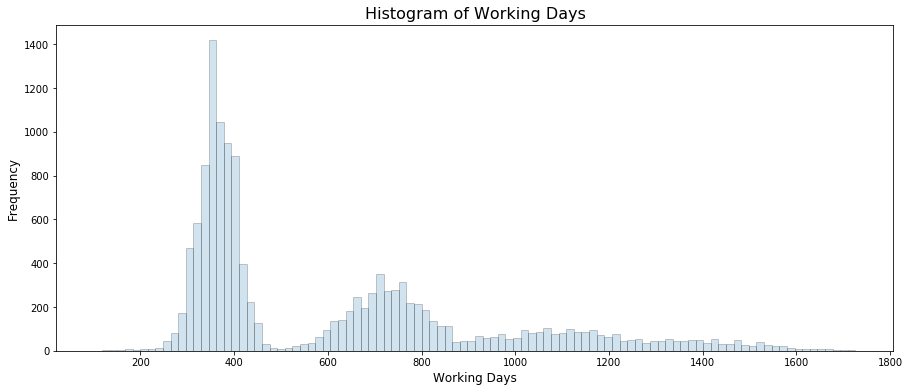

In [94]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

We can see that there are peaks around each employee year anniversary!

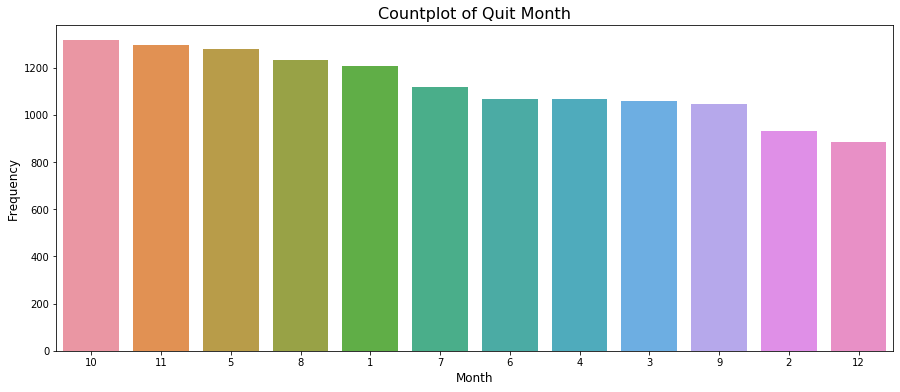

In [51]:
# month for quiting
quit_month = pd.DatetimeIndex(quit_data['quit_date']).month
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_month, ax=ax,order = quit_month.value_counts(sort = True, ascending = False).index)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

Less people quit at Dec.

In [103]:
# quiting rate for department 
data_dep = data[['dept', 'quit']].groupby('dept').mean().sort_values(by='quit',ascending=False).reset_index()
data_dep

,dept,quit
0,sales,0.570933
1,design,0.563768
2,marketing,0.562855
3,customer_service,0.554902
4,data_science,0.527273
5,engineer,0.511925


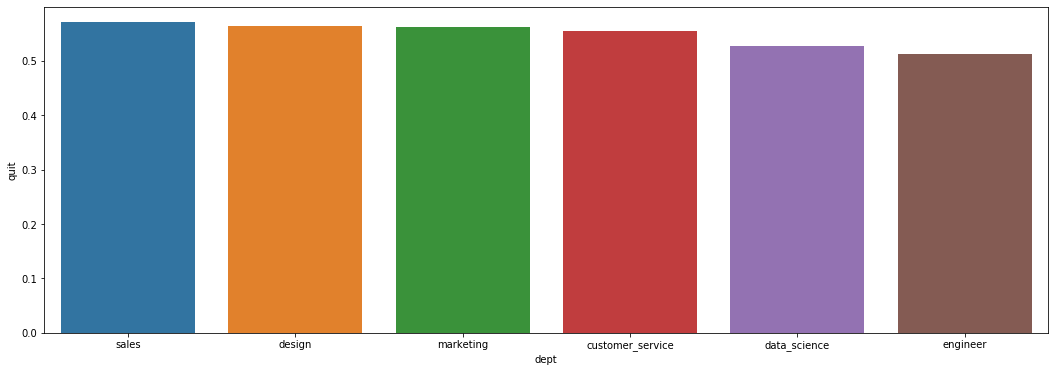

In [104]:
# visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='dept', y='quit', data=data_dep, ax=ax)
plt.show()

In [107]:
# quiting rate for company 
data_comp = data[['company_id', 'quit']].groupby('company_id').mean().sort_values(by='quit',ascending=False).reset_index()
data_comp

,company_id,quit
0,11,0.750000
1,7,0.565359
2,5,0.560114
3,4,0.559166
4,3,0.556930
5,10,0.554398
6,8,0.553009
7,6,0.551510
8,9,0.550468
9,1,0.544490


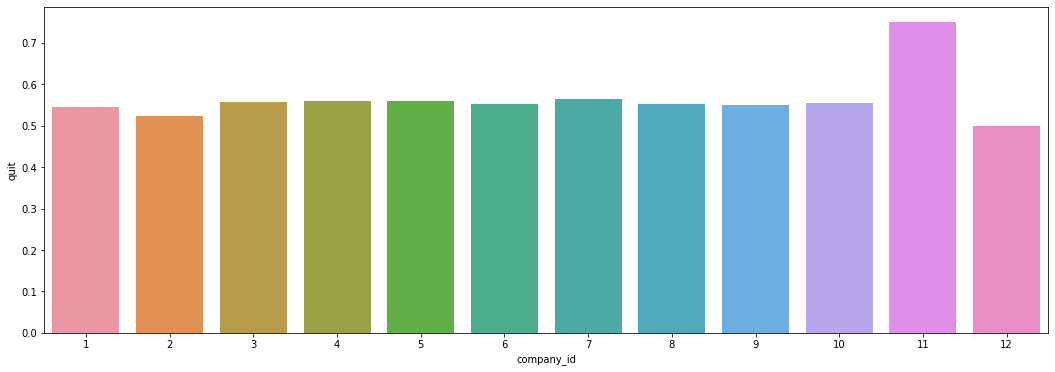

In [108]:
# visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='company_id', y='quit', data=data_comp, ax=ax)
plt.show()

In [119]:
# quiting rate for seniority  
data_sen = data[['seniority', 'quit']].groupby('seniority').mean().sort_values(by='quit',ascending=False).reset_index()
data_sen.head()

,seniority,quit
0,6,0.601053
1,12,0.590081
2,21,0.581841
3,8,0.581349
4,16,0.570513


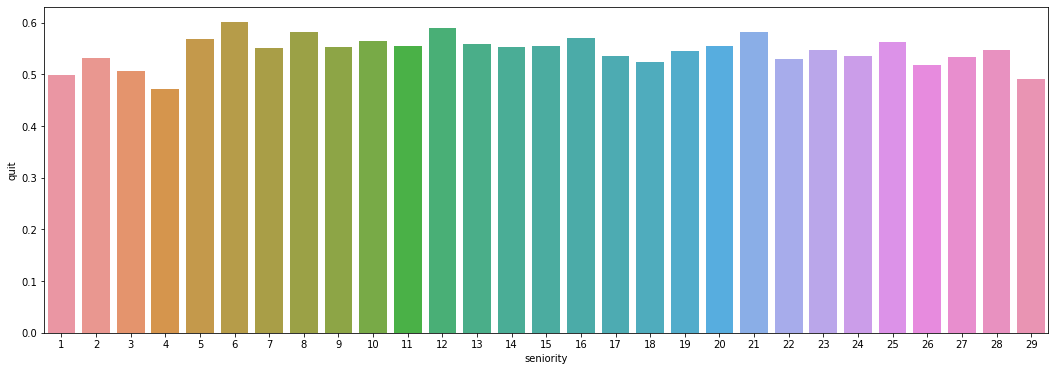

In [120]:
# sns.lineplot(data = data, x='seniority',y='quit').set_title('Mean Quit Rate VS seniority', fontsize=16)
# plt.show()
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='seniority', y='quit', data=data_sen, ax=ax)
plt.show()

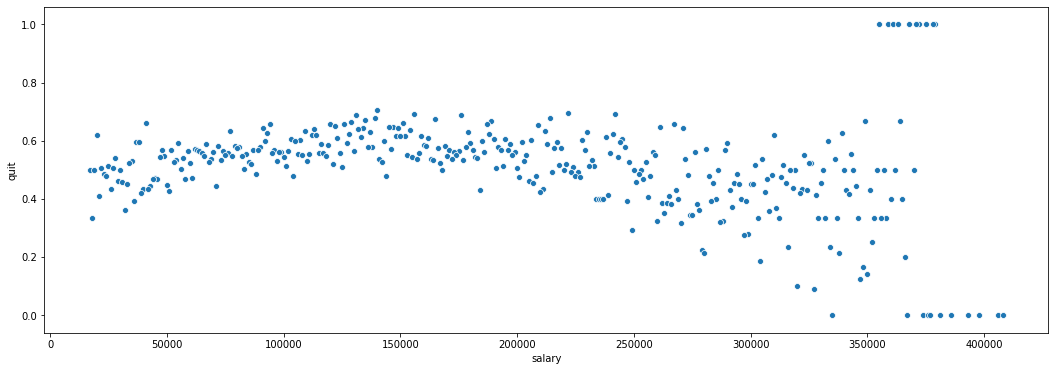

In [129]:
# quit rate vs salary distribution plot 
data_salary = data[['salary', 'quit']].groupby('salary').mean().sort_values(by='quit',ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(18, 6))
#sns.barplot(x='salary', y='quit', data=data_salary, ax=ax)
sns.scatterplot(x='salary', y='quit', data=data_salary, ax=ax)
plt.show()

In [130]:
max(data['salary'])

408000.0

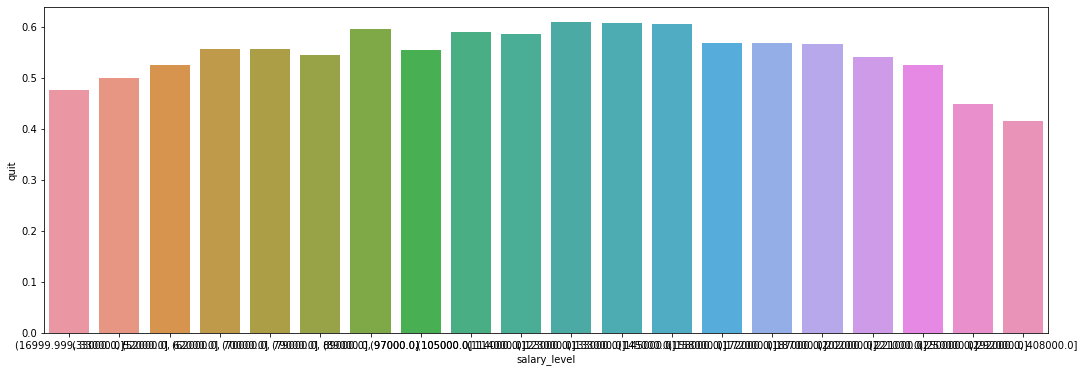

In [139]:
data['salary_level'] = pd.qcut(data['salary'], 20)
data_salary = data[['salary_level', 'quit']].groupby('salary_level').mean().sort_values(by='quit',ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='salary_level', y='quit', data=data_salary, ax=ax)
plt.show()


## Build Decision tree model for early quiter 

Now, let’s see if we find the characteristics of the people who quit early. Looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so. So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them).

In [140]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,salary_level
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,"(79000.0, 89000.0]"
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,"(172000.0, 187000.0]"
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0,"(97000.0, 105000.0]"
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,"(114000.0, 123000.0]"
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,"(250000.0, 292000.0]"


In [142]:
# One-hot encoding
subset['company_id'] = subset['company_id'].astype(str)
dummies = pd.get_dummies(subset[['company_id', 'dept']])
train_x = pd.concat(objs=[subset[['seniority', 'salary']], dummies], axis=1)
train_y = subset['quit'].values
train_x.head()

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,seniority,salary,company_id_1,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,20,183000.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,14,101000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,20,115000.0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,23,276000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [143]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

In [147]:
# Visualization
features = list(train_x.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  

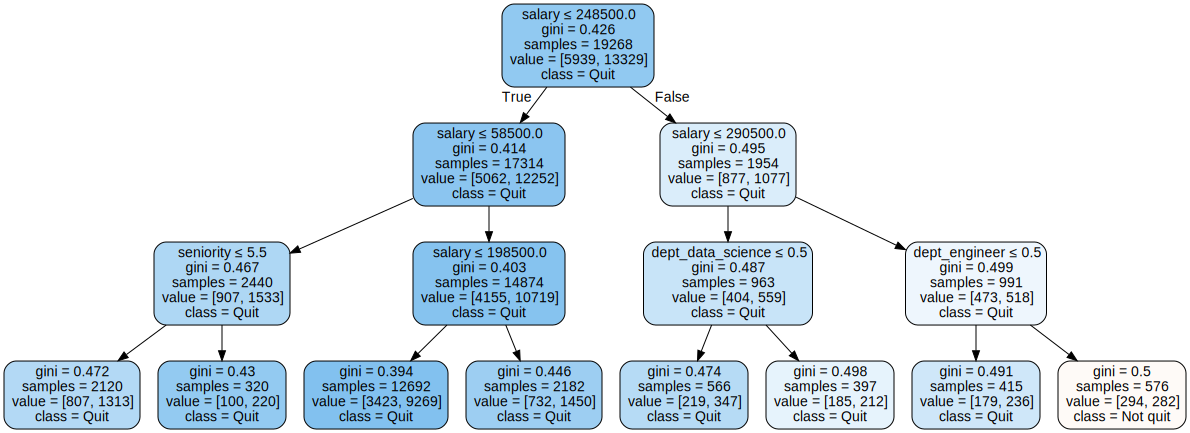

In [150]:
graph = graphviz.Source(dot_data)
graph

In [151]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.94307
dept_engineer | 0.02017
dept_data_science | 0.01950
seniority  | 0.01727
company_id_1 | 0.00000
company_id_10 | 0.00000
company_id_11 | 0.00000
company_id_12 | 0.00000
company_id_2 | 0.00000
company_id_3 | 0.00000
company_id_4 | 0.00000
company_id_5 | 0.00000
company_id_6 | 0.00000
company_id_7 | 0.00000
company_id_8 | 0.00000
company_id_9 | 0.00000
dept_customer_service | 0.00000
dept_design | 0.00000
dept_marketing | 0.00000
dept_sales | 0.00000


Not very surprising! Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

It is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 58500 and 248500, the employee has higher probability of being an early quitter, otherwise she doesn’t. That means that people who make a lot of money and very little are not likely to quit.

## Conclusion
1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.